## Consider a square plate with sides $[−1, 1] × [−1, 1]$. At time $t = 0$ we are heating the plate up such that the temperature is $u = 5$ on one side and $u = 0$ on the other sides. The temperature evolves according to $u_t$ = $∆u$.

### Import necessary packages

In [1]:
%matplotlib inline
import numpy as np
from numba import njit, prange
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import pyopencl as cl
from scipy.sparse import csr_matrix, csc_matrix, linalg
import scipy
from numba.typed import List
from scipy.sparse.linalg import LinearOperator,cg,spilu
import numexpr as ne

### Define indexing for explicit finite difference method

I will be defining $u$ as a vector to describe the inner nodes of the domain. The first element of $u$ will denote the top-left of the matrix, and sequential elements will move through the matrix to the right, and then down. There will be implied boundary condition of $u=0$ on the left, top, and bottom boundaries, and $u=5$ on the right boundary. Below is a simple example of my indexing:

$u = [1,2,3,4,5,6,7,8,9]$

Matrix representation:

$ 0,0,0,0,0$<br>
$-----$<br>
$0 | 1, 2, 3 | 5$<br>
$0 | 4, 5, 6 | 5$<br>
$0 | 7, 8, 9 | 5$<br>
$-----$<br>
$ 0,0,0,0,0$<br>

### Implement explicit finite difference method

Here I am using the explicit finite difference method (Forward Euler Method) to estimate how heat moves through the plate with time. In the explicit method, there is a direct formula to solve for the heat at each node throughout the plate. I will first represent the domain of the plate as a matrix of nodes. The heat at timestep $(n+1)$, with $\mu=\dfrac{∆t}{{(∆x)}^2}$ will be calculated as:<br> $u_{i,j}^{n} =(1-4\mu)*u_{i,j}^{n}+\mu*(u_{i-1,j}^{n}+u_{i+1,j}^{n}+u_{i,j-1}^{n}+u_{i,j+1}^{n})$<br><br>
The function includes 2 hyper-parameters $M$ and $∆t$. $M$ will represent the dimensions of the martix representing the plate. For instance, if $M=3$, then the inner matrix will be $3x3$, and the outer matrix will be $5x5$ thus $∆x=0.5$, as a length-$2$ distance will be split into $4$ sections. The other hyper-parameter is $∆t$, which will determine the time difference at each step. The function will iterate through timesteps until the middle node has $u=1$, at which time it will return $∆t*$(number of steps). I will use Numba to pre-compile  and parallelize the timestep operation. Since the calculation of each node is independent from the others, this is a suitable method to parallelize. It is important to note that explicit methods are conditionally stable, and must satisfy $4\leq\dfrac{(∆x)^2}{∆t}$. I would also like to mention that I tried to use the symmetry of the system to speed up computation by first computing the top half, then copying it symmetrically to the bottom half. It turned out that this method was actually slower, likely because the regular computation is quite small, and copying the updated nodes requires a second parallel loop.

In [2]:
@njit(parallel=True) # Numba-accelerate function and parallelize
def solve_explicit(M, delta_t):
    u = np.zeros(M**2) # Define u by size of M
    h = 2 / (M + 1) # Calculate ∆x as defined above
    time_fac = delta_t / (h**2) # Calculate mu value as defined above
    iterations = 0 # Store number of iterations
    # Iterate through steps and check if middle value exceeds 1.0.
    while u[int((M**2-1)/2)] < 1.0:
        # Create variable to hold u at next timestep. It is important to note
        # that you cannot make changes in places since each node depends on
        # adjacent nodes.
        u_new = np.zeros(len(u)) 
        # Iterate through each node in u using 'prange' so each calculation is
        # parallelized.
        for i in prange(len(u)):
            u_new[i] = (1-4*time_fac)*u[i] # Add multiple of current node
            if i >= M:
                u_new[i] += time_fac * u[i-M] # Add multiple of above node
            if i < M**2 - M:
                u_new[i] += time_fac * u[i+M] # Add multiple of below node
            if (i % M) > 0:
                u_new[i] += time_fac * u[i-1] # Add multiple of left node
            if (i % M) < M - 1:
                u_new[i] += time_fac * u[i+1] # Add multiple of right node
            else:
                u_new[i] += time_fac * 5 # Use 5-boundary if on right boundary
        iterations += 1 # Update iterations
        u = u_new # Save updated u
    return iterations*delta_t 

Here I am performing the same solution as above, but with opencl. Since opencl can parallelize each timestep operation and run as efficient C-code, this is a suitable solution.

In [3]:
# Here I have defined the string to run the function.
prg_str = """
    __kernel void step_time(
        double delta_t,
        __global const double *u_g,
        __global double *res_g,
        __global bool *finished)
    {
        int gid = get_global_id(0); // Get location in buffer
        int u_size = get_global_size(0); // Get total size of u vector
        int M = sqrt(double(u_size)); // Calculate M from total size
        double h = 2.0 / (M + 1); // Calculate h from M
        double time_fac = (delta_t / (h*h)); // Calculate time factor
        // Initialize stencil to 0
        double stencil = 0;
        // Check position above is an edge, if not add it (otherwise 0)
        if (gid - M >= 0) stencil += u_g[gid - M];
        // Check position below is an edge, if not add it (otherwise 0)
        if (gid + M < u_size) stencil += u_g[gid + M];
        // Check position to left is an edge, if not add it (otherwise 0)
        if (gid % M) stencil += u_g[gid - 1];
        // Check position to right is an edge, if not add it 
        if ((gid + 1) % M) {
            stencil += u_g[gid + 1];
        } else { // if boundary is to right, apply boundary condition of 5
            stencil += 5;
        }
        stencil *= time_fac; // Multiply stencil by factor
        stencil += (1 - 4*time_fac) * u_g[gid]; // Add factore from this node
        res_g[gid] = stencil; // Store result // Set result
        // Check if middle value is > 1.0, it which case set the finished flag
        if (gid == (u_size - 1) / 2 & stencil > 1.0) {
            finished[0] = true;
        }
    }    
    """

def solve_explicit_opencl(M, delta_t, prg_str=prg_str):
    u = np.zeros(M**2) # Define inner-matrix u based on size M
    ctx = cl.create_some_context() # Create a context
    queue = cl.CommandQueue(ctx) # Queue initialisation

    # Copy existing numpy array onto device. Also set memory flags accordingly.
    mf = cl.mem_flags
    # This buffer will hold the initial value of u and copy it over to the device.
    u1_g = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,hostbuf=u)
    # This will be a second buffer to hold the result after a timestep
    u2_g = cl.Buffer(ctx,  mf.READ_WRITE, u.nbytes)
    # This is a flag set on the device to check if u=1.0 in the center
    finished = cl.Buffer(ctx,  mf.READ_WRITE, 1)

    # This program will compute the 5-point stencil for single value in u. It
    # has the exact same functionality as the Numba method above. It also
    # updates the finished flag at the end by checking the center value of the
    # matrix. This is an important step because I will not have to copy back the
    # whole result at each timestep, and will instead only copy over a single
    # byte.
    prg = cl.Program(ctx, prg_str).build()

    # Call the step_time function to run on the OpenCL Kernel. Provide proper
    # inputs to function and use u.shape to iterate through all nodes in the
    # matrix.
    fin_flag = False # Set finished flag to false, meaning center value < 1.0
    iterations = 0
    # Iteration until finished flag is true, when center value is 1.0
    while (not fin_flag):
        # Run the program using u1_g, and store the updated value in u2_g.
        prg.step_time(queue, u.shape, None, np.float64(delta_t), u1_g, u2_g, finished)
        iterations += 1
        # Check the finished flag, and break if it has been set off
        fin_flag,_ = cl.enqueue_map_buffer(queue, finished, 
                                           cl.map_flags.READ,0,(1,), np.bool)
        if fin_flag:
            break
        # At this stage the current state is stored in u2_g. For this reason, I will
        # use u2_g as the input, and store the result in u1_g. This method saved
        # significant time compared to copying final value back to u1_g at each step.
        # There is no copying necessary as the solution is moved back and forth at 
        # each iteration.
        prg.step_time(queue, u.shape, None, np.float64(delta_t), u2_g, u1_g, finished)
        # Check the finished flag, and break if it has been set off
        fin_flag,_ = cl.enqueue_map_buffer(queue, finished, 
                                           cl.map_flags.READ,0,(1,), np.bool)
        iterations += 1
    queue.finish()
    return iterations * delta_t

### Implement implicit finite difference method

#### Define indexing for implicit finite difference method

Please note that my indexing will slightly change for the implicit models. This is because the boundaries must be included as I will be solving a system of equations. For the explicit methods, it was simpler to not include them and infer the values. The biggest change from this scheme is that a size $M$ matrix here will be equivalent to a size $M-2$ matrix from above, as the $M$ value will now include the boundaries. Below is an example of an $M=4$ matrix in this new indexing scheme:


$u=[0, 0, 0, 5, 0, 1, 2, 5, 0, 3, 4, 5, 0, 0, 0, 5]$

Matrix representation:

$|0,0,0,5|$<br>
$|0,1,2,5|$<br>
$|0,3,4,5|$<br>
$|0,0,0,5|$

#### Define class for preconditioner matrix

This is a class which which will hold a preconditioner matrix using ILU decomposition. It is useful to provide a preconditioner when solving $Ax=b$ by estimating $A^{-1}$. Since we could solve such an equation as $A^{-1}b=x$, having a good estimate can significantly speed up computation. The class will take in the matrix $A$, a drop tolerance, and a fill factor. Having a small drop tolerance can be useful to compute the matrix quicker. The fill factor will be used to estimate how much memory is necessary to prealocate for the array. For sparse matrices, it can be useful to have a small fill factor, you will not waste space and time over-allocating memory. For the implicit difference method, a sparse matrix will be used to calculate each time step, thus setting good parameters can be essential for efficiency.

In [4]:
class Precon(LinearOperator):
    
    # Take in A matrix, drop tolerance, and a fill factor.
    def __init__(self,A,drop,fill):
        self.shape = A.shape # Set shape to be same as A matrix
        self.dtype = np.dtype(np.float64) # Set dtype to float
        # Set ILU matrix to be ILU factorization of matrix A, using the
        # provided drop tolerance and fill factor. This will be used as a 
        # preconditioner for the cg solver. Note that I have also converted 
        # A from CSR format to CSC, as spilu previously gave me a warning 
        # that CSC format is preferred.
        self.ILU = spilu(csc_matrix(A), drop_tol = drop, fill_factor = fill)
    
    # Define matvec function as solve method in ILU matrix.
    def _matvec(self,u):
        return self.ILU.solve(u)

#### Construct matrix to compute implicit timestep

Here I am using the implicit finite difference method (Backward Euler Method) to estimate how heat moves through the plate with time. In the implicit method, there is no direct formula to solve for the heat at each node throughout the plate. The heat at timestep $n$, with $\mu=\dfrac{∆t}{{(∆x)}^2}$ will be defined as:<br> $u_{i,j}^{n} =(1+4\mu)*u_{i,j}^{n+1}-\mu*(u_{i-1,j}^{n+1}+u_{i+1,j}^{n+1}+u_{i,j-1}^{n+1}+u_{i,j+1}^{n+1})$<br><br>
For this reason we will need to create a matrix $A$ which will represent the coefficients for the heat at time $(n+1)$, and b will represent the coefficients at time $n$. We will then use $Ax=b$, and solve for $x$ to get the heat at the next time step. I will use Numba to pre-compile  and parallelize matrix construction. Since the calculation of each node is independent from the others, this is a suitable method to parallelize. It is important to note that the implicit method is unconditionally stable, thus $∆x$ and $∆t$ can be set without having any constraints. This function produces the matrix $A$ in COO format by filling in row, column, and data vectors. Since appending to these vectors would be problematic for a parallelized function, I pre-define the size of each vector based on the size of domain. I create a matrix starting_points which will state the starting point for each node in the domain in the COO vectors . This will allow me to pre-allocate these COO vectors, and add elements in parallel.

In [5]:
@njit(parallel=True)
def construct_back_matrix(u, delta_t):
    M = int(np.sqrt(len(u))) # Define size M based on u
    # Initialize matrix to hold starting points for each node in the COO
    # vectors.
    starting_points = np.zeros(len(u), dtype = np.int32)
    start_idx = 0
    # Iterate through each node and track the starting index of each. If it
    # is on the edge, we will increase index by 1, as repeats itselft for
    # the next iteration. If it is a central node, we will increase the index
    # by 5 as it references the 4 adjecent nodes and itself.
    for i in range(len(u)):
        starting_points[i] = start_idx
        if (i < M or i >= M**2 - M or (i % M) == 0 or (i % M) == M - 1):
            start_idx += 1
        else:
            start_idx += 5
    h = 2 / (M - 1)
    time_fac = delta_t / h**2
    
    # Define COO vectors of ending value of start_idx. This will have
    # the total length of each vector.
    row_vec = np.zeros(start_idx, dtype=np.int32)
    col_vec = np.zeros(start_idx, dtype=np.int32)
    dat_vec = np.zeros(start_idx, dtype=np.float64)
    
    # Iterate through all nodes in domain and add to COO vectors
    # accordingly.
    for i in prange(len(u)):
        # Get starting point for this node
        start = starting_points[i]
        # If it is an edge node, add point (i,i) with value 1 in order to
        # get identity of this node for the next iteration.
        if (i < M or i >= M**2 - M or (i % M) == 0 or (i % M) == M - 1):
            row_vec[start] = i
            col_vec[start] = i
            dat_vec[start] = 1.0
        else:
        # If it is a central node we will repeat current location 5 times
        # to denote 5 operations on this node. We will then add 5 items
        # to column vector denoting 4 adjacent nodes and current node to 
        # operate on. We will then at 5 operations to data vector, the first
        # representing the operation on itself, and the next 4 being 
        # operations on the adjacent nodes.
            row_vec[start] = i
            row_vec[start+1] = i
            row_vec[start+2] = i
            row_vec[start+3] = i
            row_vec[start+4] = i
            col_vec[start] = i
            col_vec[start+1] = i-1
            col_vec[start+2] = i+1
            col_vec[start+3] = i-M
            col_vec[start+4] = i+M
            dat_vec[start] = 1 + (4*time_fac)
            dat_vec[start+1] = -time_fac
            dat_vec[start+2] = -time_fac
            dat_vec[start+3] = -time_fac
            dat_vec[start+4] = -time_fac
    return dat_vec, row_vec, col_vec, M # Return COO matrix and shape

Here I am performing the same task as above, but with an opencl implementation. I begin by initializing the array of starting indices, then compute the COO vectors on the opencl device in parallel.

In [6]:
# Here I have defined the string to run the function.
constr_str  = """
    __kernel void step_time(
        double delta_t,
        __global const int *starts_g,
        __global const double *u_g,
        __global int *row_g,
        __global int *col_g,
        __global double *dat_g)
    {
        int gid = get_global_id(0); // Get location in buffer
        int u_size = get_global_size(0); // Get total size of u vector
        int M = sqrt(double(u_size)); // Calculate M from total size
        double h = 2.0 / (M - 1); // Calculate h from M
        double time_fac = (delta_t / (h*h));
        int start = starts_g[gid];
        // If it is an edge node, add point (i,i) with value 1 in order to
        // get identity of this node for the next iteration.
        if (gid < M | gid >= M*M - M | (gid % M) == 0 | (gid % M) == M - 1) {
            row_g[start] = gid;
            col_g[start] = gid;
            dat_g[start] = 1.0;
        } else {
        // If it is a central node we will repeat current location 5 times
        // to denote 5 operations on this node. We will then add 5 items
        // to column vector denoting 4 adjacent nodes and current node to 
        // operate on. We will then at 5 operations to data vector, the first
        // representing the operation on itself, and the next 4 being 
        // operations on the adjacent nodes.
            row_g[start] = gid;
            row_g[start+1] = gid;
            row_g[start+2] = gid;
            row_g[start+3] = gid;
            row_g[start+4] = gid;
            col_g[start] = gid;
            col_g[start+1] = gid-1;
            col_g[start+2] = gid+1;
            col_g[start+3] = gid-M;
            col_g[start+4] = gid+M;
            dat_g[start] = 1 + (4*time_fac);
            dat_g[start+1] = -time_fac;
            dat_g[start+2] = -time_fac;
            dat_g[start+3] = -time_fac;
            dat_g[start+4] = -time_fac;
        }         
    }    
    """

# This is the function to contruct the matrix using opencl
def construct_back_matrix_opencl(u,delta_t, constr_str=constr_str):
    M = int(np.sqrt(len(u))) # Define size M based on u
    # Initialize matrix to hold starting points for each node in the COO
    # vectors.
    starting_points = np.zeros(len(u), dtype = np.int32)
    start_idx = 0
    # Iterate through each node and track the starting index of each. If it
    # is on the edge, we will increase index by 1, as repeats itselft for
    # the next iteration. If it is a central node, we will increase the index
    # by 5 as it references the 4 adjecent nodes and itself.
    for i in range(len(u)):
        starting_points[i] = start_idx
        if (i < M or i >= M**2 - M or (i % M) == 0 or (i % M) == M - 1):
            start_idx += 1
        else:
            start_idx += 5
    
    ctx = cl.create_some_context() # Create a context
    queue = cl.CommandQueue(ctx) # Queue initialisation

    # Copy existing numpy array onto device. Also set memory flags accordingly.
    mf = cl.mem_flags
    u_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,hostbuf=u)
    starts_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,hostbuf=starting_points)
    
    # Run program string on device.
    prg = cl.Program(ctx,constr_str).build()

    # Create a result buffer containing the context, a write_only flag, and 
    # the proper number of bytes.
    row_g = cl.Buffer(ctx, mf.WRITE_ONLY, (start_idx) * 4)
    col_g = cl.Buffer(ctx, mf.WRITE_ONLY, (start_idx) * 4)
    dat_g = cl.Buffer(ctx, mf.WRITE_ONLY, (start_idx) * 8)
    
    # Call the step_time function to run on the OpenCL Kernel. Provide  proper
    # inputs to function and use u.shape to iterate through all
    # rows in the matrix.
    prg.step_time(queue, u.shape, None, np.float64(delta_t),
                  starts_g, u_g, row_g, col_g, dat_g)
    
    # Copy COO vectors over from the device and return along with shape
    row_vec,_ = cl.enqueue_map_buffer(queue, row_g, 
                                      cl.map_flags.READ, 0, (start_idx,), np.int32)
    col_vec,_ = cl.enqueue_map_buffer(queue, col_g, 
                                      cl.map_flags.READ, 0, (start_idx,), np.int32)
    dat_vec,_ = cl.enqueue_map_buffer(queue, dat_g, 
                                      cl.map_flags.READ, 0, (start_idx,), np.float64)
    return dat_vec, row_vec, col_vec, M

Here I will run the step function in iterations until $u = 1.0$ in the center. I will update $u$ accordingto $Au^{n+1}=u^n$ and use cg with a preconditioner to solve the system.

In [7]:
def solve_implicit(M, delta_t, constr_mat, drop_tol, fill_fac):
    u = np.zeros((M,M))
    u[:][M-1] = 5
    u = u.flatten() # Construct u from M
    # Construct CSR matrix A based on one of the function above
    dat_vec, row_vec, col_vec, M = constr_mat(u, delta_t)
    A = csr_matrix((dat_vec, (row_vec, col_vec)), (len(u),len(u)))
    # Define preconditioner matrix
    P = Precon(A,drop_tol,fill_fac)
    iterations = 0
    # Iterate through solver until u=1.0 in the center
    while u[int((M**2-1)/2)] < 1.0:
        u,_ = cg(A,u,M=P)
        iterations += 1
    return iterations * delta_t

This is an implementation of the implicit Crank-Nicolson Method. It is very similar to the Backward Euler Method, however it follows the formula (with $\mu=\dfrac{∆t}{{(∆x)}^2}$):<br>
$(1+2\mu)u_{i,j}^{n+1}-\dfrac{\mu}{2}(u_{i+1,j}^{n+1}+u_{i-1,j}^{n+1}+u_{i,j+1}^{n+1}+u_{i,j-1}^{n+1})$<br>
$= (1-2\mu)u_{i,j}^{n}+\dfrac{\mu}{2}(u_{i+1,j}^{n}+u_{i-1,j}^{n}+u_{i,j+1}^{n}+u_{i,j-1}^{n})$<br>
The Crank-Nicolson Method will essentially compute the average of the Forward and Backward Euler methods, and is also unconditionally stable, however requires a low $\mu$ value for greater accuracy. The Crank Nicolson Method is mathematically superior to the previous two methods becase it is a central difference method, having quadratic convergence in $h$, as opposed to linear. The below function will create the equivalent matrix for the coefficients of $u^{n+1}$, which is only a slight modification of other matrix construction methods. Through trial, I have found that the Numba-accelerated matrix generator is slight faster, so I will only implement this Crank Nicolson

In [8]:
@njit(parallel=True)
def construct_crank_matrix(u, delta_t):
    M = int(np.sqrt(len(u))) # Define size M based on u
    # Initialize matrix to hold starting points for each node in the COO
    # vectors.
    starting_points = np.zeros(len(u), dtype = np.int32)
    start_idx = 0
    # Iterate through each node and track the starting index of each. If it
    # is on the edge, we will increase index by 1, as repeats itselft for
    # the next iteration. If it is a central node, we will increase the index
    # by 5 as it references the 4 adjecent nodes and itself.
    for i in range(len(u)):
        starting_points[i] = start_idx
        if (i < M or i >= M**2 - M or (i % M) == 0 or (i % M) == M - 1):
            start_idx += 1
        else:
            start_idx += 5
    h = 2 / (M - 1)
    time_fac = delta_t / h**2
    
    # Define COO vectors of ending value of start_idx. This will have
    # the total length of each vector.
    row_vec = np.zeros(start_idx, dtype=np.int32)
    col_vec = np.zeros(start_idx, dtype=np.int32)
    dat_vec = np.zeros(start_idx, dtype=np.float64)
    
    # Iterate through all nodes in domain and add to COO vectors
    # accordingly.
    for i in prange(len(u)):
        start = starting_points[i]
        # If it is an edge node, add point (i,i) with value 1 in order to
        # get identity of this node for the next iteration.
        if (i < M or i >= M**2 - M or (i % M) == 0 or (i % M) == M - 1):
            row_vec[start] = i
            col_vec[start] = i
            dat_vec[start] = 1.0
        else:
        # If it is a central node we will repeat current location 5 times
        # to denote 5 operations on this node. We will then add 5 items
        # to column vector denoting 4 adjacent nodes and current node to 
        # operate on. We will then at 5 operations to data vector, the first
        # representing the operation on itself, and the next 4 being 
        # operations on the adjacent nodes.
            row_vec[start] = i
            row_vec[start+1] = i
            row_vec[start+2] = i
            row_vec[start+3] = i
            row_vec[start+4] = i
            col_vec[start] = i
            col_vec[start+1] = i-1
            col_vec[start+2] = i+1
            col_vec[start+3] = i-M
            col_vec[start+4] = i+M
            dat_vec[start] = 1 + (2*time_fac)
            dat_vec[start+1] = -time_fac / 2
            dat_vec[start+2] = -time_fac / 2
            dat_vec[start+3] = -time_fac / 2
            dat_vec[start+4] = -time_fac / 2
    return dat_vec, row_vec, col_vec, M # Return COO matrix and shape

This function is used to explicitly compute the right-hand-side of the Crank-Nicolson equation. It is easily parallizable and significantly quicker than a non-parallel solution. 

In [9]:
@njit(parallel=True)
def get_crank_RHS_Numba(u,M,time_fac):
    u_RHS = np.copy(u)
    for i in prange(len(u)):
        if not(i < M or i >= M**2 - M or (i % M) == 0 or (i % M) == M - 1):
            u_RHS[i] = (1-2*time_fac)*u[i] + \
                (time_fac/2)*(u[i-1]+u[i+1]+u[i-M]+u[i+M])
    return u_RHS

This function is the same as above, but uses numexpr to evaluate the computation as opposed to Numba. I found that this implementation is considerably slower, so I only use the Numba version in my solver.

In [10]:
def get_crank_RHS_numexpr(u,M,time_fac):
    u_RHS = np.copy(u)
    for i in range(len(u)):
        if not(i < M or i >= M**2 - M or (i % M) == 0 or (i % M) == M - 1):
                u_i = u[i]
                u_left = u[i-1]
                u_right = u[i+1]
                u_above = u[i-M]
                u_below = u[i+M]
                u_RHS[i] = ne.evaluate("(1-2*time_fac)*u_i + \
                                       (time_fac/2) * \
                                       (u_left+u_right+u_above+u_below)")
    return u_RHS

Below is the solver for the Crank Nicolson Method. It is very similar to the solver for the implicit methods with one variation. As opposed to using $u_n$ as the right-hand-side of the equation at each iteration, we will need to calculate the right-hand-side explicitly at each time step based on the Crank Nicolson formula.

In [11]:
def solve_implicit_crank(M, delta_t, drop_tol, fill_fac):
    u = np.zeros((M,M))
    u[:][M-1] = 5
    u = u.flatten() # Construct u from M
    h = 2 / (M - 1)
    time_fac = delta_t / h**2 # Get mu value
    # Construct CSR matrix A based on one of the function above
    dat_vec, row_vec, col_vec, M = construct_crank_matrix(u, delta_t)
    A = csr_matrix((dat_vec, (row_vec, col_vec)), (len(u),len(u)))
    # Define preconditioner matrix
    P = Precon(A,drop_tol,fill_fac)
    # Define vector to hold right-hand-side of formula. This will be an
    # explicit function of u_n
    u_RHS = np.zeros(len(u))
    iterations = 0
    # Iterate through solver until u=1.0 in the center
    while u[int((M**2-1)/2)] < 1.0:
        # Explicitly compute right-hand-side of equation based on Crank
        # Nicolson formula with Numba-accelerated function above.
        u_RHS = get_crank_RHS_Numba(u,M,time_fac)
        u,_ = cg(A,u_RHS, M = P) # Apply iterative solver.
        iterations += 1
    # Note that I have return the final time as well as the completed
    # matrix for graphing purposes.
    return iterations * delta_t, u

### Visualize plate when $u=1.0$ in center

Below is a general function to plot the heat on the plate when $u=1.0$ in the center. I have used the Crank Nicholson Method, pre-set the drop factor to $10^{-8}$ and pre-set the fill factor to $\dfrac{5}{M^2}$

In [12]:
def plot_u_at_M(M,delta_t,drop=1e-8):
    _,u = solve_implicit_crank(M, delta_t, 1e-8, 5/M**2)
    u = u.reshape(M,M) # Reshape u into M x M matrix

    h = (1 / (M + 1)) # Get h value based on matrix
    x = np.arange(0,1,h)[1:M + 1] # Get x range along unit square
    y = np.arange(0,1,h)[1:M + 1] # Get y range along unit square

    # Make heatmap of u on unit square of x,y
    X,Y = np.meshgrid(x,y) 
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X, Y, u, cmap=cm.gist_heat)
    plt.title('Plot of u where M = ' + str(M), fontsize = 20)
    plt.xlabel('x', fontsize = 15)
    plt.ylabel('y', fontsize = 15)
    plt.show()

Plot final heat map where $M=11$ in grid

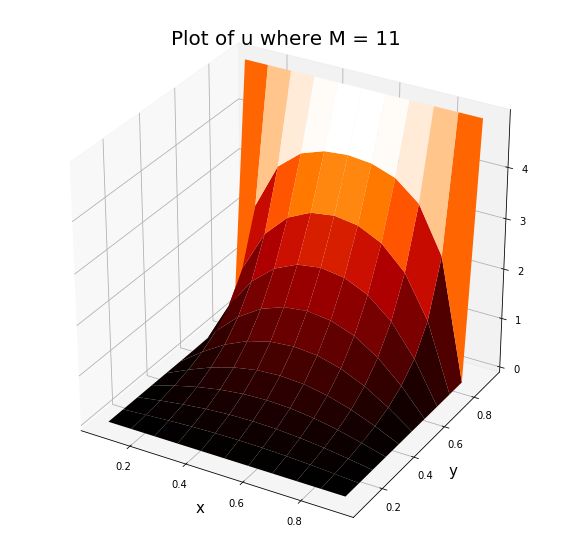

In [13]:
M = 11
delta_t = .01 # Provide approprate timestep
plot_u_at_M(M,delta_t)

Plot final heat map where $M=51$ in grid

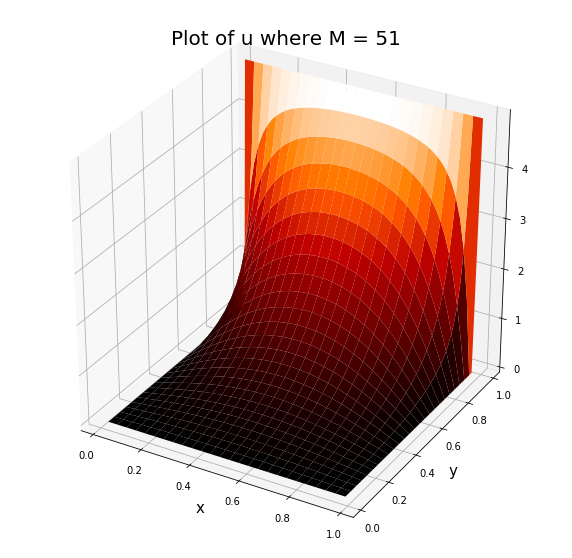

In [14]:
M = 51
delta_t = .001 # Provide approprate timestep
plot_u_at_M(M,delta_t)

It is clear to see from these images that a higher value of $M$ will result in a more accurate solution, as the surface begins to resemble curves as opposed to jagged lines

### Compare accuracy of explicit solutions

My Numba and OpenCL solutions for the Forward Euler Methods should return identical results, so below I will verify that they are both working properly

In [15]:
M_vals = [7,11,13,17,21]
delta_t_vals = [.002,.001,.0007,.0005,.0003]
for i in range(len(M_vals)):
    numba_sol = solve_explicit(M_vals[i],delta_t_vals[i])
    opencl_sol = solve_explicit_opencl(M_vals[i],delta_t_vals[i])
    assert numba_sol == opencl_sol

### Compare timing of explicit solutions

Now that I have verified that these functions return identical results, I will investigate which is faster. 

#### Helper function to time a method

In [16]:
def time_method(method,M_or_u,delta_t):
    start = time.time()
    method(M_or_u,delta_t)
    return time.time() - start

#### Investigate timing as size $M$ of domain increases for explicit methods

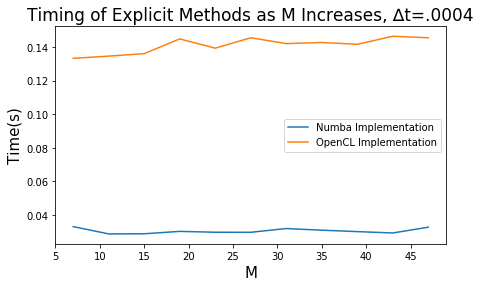

In [17]:
M_vals = np.linspace(7,47,11,dtype=int)
delta_t = .0004
numba_times = []
opencl_times = []
for M in M_vals:
    numba_times.append(time_method(solve_explicit,M,delta_t))
    opencl_times.append(time_method(solve_explicit_opencl,M,delta_t))
plt.figure(figsize=(7,4))
plt.plot(M_vals,numba_times)
plt.plot(M_vals,opencl_times)
plt.title("Timing of Explicit Methods as M Increases, ∆t=.0004",fontsize = 17)
plt.xlabel("M",fontsize=15)
plt.ylabel("Time(s)",fontsize=15)
plt.legend(["Numba Implementation","OpenCL Implementation"])
plt.show()

#### Investigate timing as size $∆t$ decreases for explicit methods

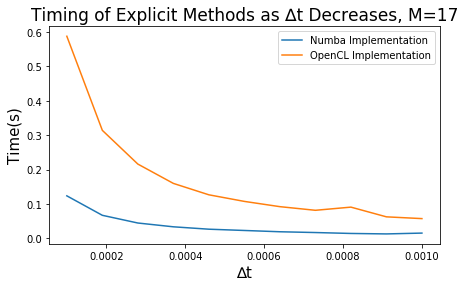

In [18]:
M = 17
delta_t_vals = np.linspace(.001,.0001,11)
numba_times = []
opencl_times = []
for delta_t in delta_t_vals:
    numba_times.append(time_method(solve_explicit,M,delta_t))
    opencl_times.append(time_method(solve_explicit_opencl,M,delta_t))
plt.figure(figsize=(7,4))
plt.plot(delta_t_vals,numba_times)
plt.plot(delta_t_vals,opencl_times)
plt.title("Timing of Explicit Methods as ∆t Decreases, M=17",fontsize = 17)
plt.xlabel("∆t",fontsize=15)
plt.ylabel("Time(s)",fontsize=15)
plt.legend(["Numba Implementation","OpenCL Implementation"])
plt.show()

There are 3 important takeaways from the above experiments. First it seems clear that the Numba solution is faster than the opencl implementation regardless of hyperparameters. For this reason, I will only use the Numba implementation for all future tests. The other two iteresting takeaways are that the timing increases at a slow linear rate as $M$ increases, and at a quick quadratic rate as $∆t$ decreases. This hints that the parallelization of the timestep function has proved effective, as the size of the domain is not a huge factor for performance.

### Compare accuracy of implicit solutions

My Numba and OpenCL solutions for the Backward Euler Methods should return identical results, so below I will verify that they are both working properly. Since they both use the same solve function and only differ in the matrix construction, I will validate that they produce the same sparse matrices.

In [19]:
M_vals = [7,11,13,17,21]
delta_t_vals = [.002,.001,.0007,.0005,.0003]
for i in range(len(M_vals)):
    # Construct u from M
    u = np.zeros((M_vals[i],M_vals[i]))
    u[:][M_vals[i]-1] = 5
    u = u.flatten()
    numba_sol = construct_back_matrix(u,delta_t_vals[i])
    opencl_sol = construct_back_matrix_opencl(u,delta_t_vals[i])
    # Iterate through all values of COO matrices. Recall that these functions
    # will return row_vec, col_vec, dat_vec, M. Thus I will iteratively check
    # that every single value is identical.
    for j in range(len(numba_sol)):
        if type(numba_sol[j]) == int:
            assert numba_sol[j] == opencl_sol[j]
        else:
            assert all(numba_sol[j] == opencl_sol[j])

### Compare timing of implicit solutions

Now that I have verified that these functions return identical results, I will investigate which is faster.

#### Investigate timing as size $M$ of domain increases for implicit matrix construction

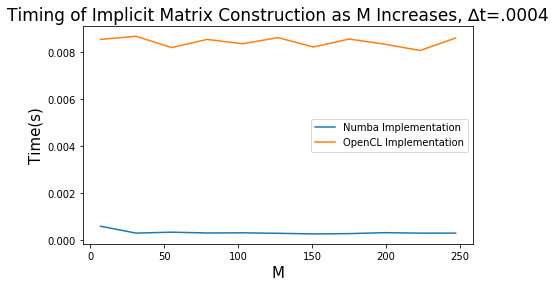

In [20]:
M_vals = np.linspace(7,247,11,dtype=int)
delta_t = .0004
numba_times = []
opencl_times = []
for M in M_vals:
    u = np.zeros((M_vals[i],M_vals[i]))
    u[:][M_vals[i]-1] = 5
    u = u.flatten()
    numba_times.append(time_method(construct_back_matrix,u,delta_t))
    opencl_times.append(time_method(construct_back_matrix_opencl,u,delta_t))
plt.figure(figsize=(7,4))
plt.plot(M_vals,numba_times)
plt.plot(M_vals,opencl_times)
plt.title("Timing of Implicit Matrix Construction as M Increases, ∆t=.0004",fontsize = 17)
plt.xlabel("M",fontsize=15)
plt.ylabel("Time(s)",fontsize=15)
plt.legend(["Numba Implementation","OpenCL Implementation"])
plt.show()

Note that it is not necessary here to investigate timing as $∆t$ changes as this only changes values within the matrix, and does not affect run time. There are two important takeaways from the above experiment. First both of the matrix constructions are extremely fast, even at large $M$, and will not be a huge factor in either implicit method as they must only be called once. Second, the Numba method seems to be consistently faster, so I will only use this implementation going forward.

### Compare timing with different drop values in Backward Euler and Crank Nicolson

Here I will compare the timing using different drop values to precondition both the Backward Euler and Crank Nicolson Methods. The accuracy of each of these functions will not change with the drop factor, so only the timing is important.

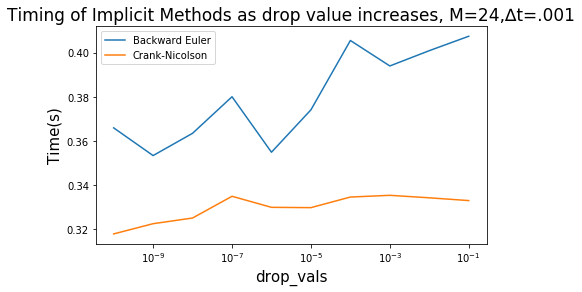

In [21]:
M = 27 # Set size of domain
delta_t = .001 # Set reasonable time step
# Look at drop values of the form 1e-1,1e-2,...,1e-10
drop_vals = [10**-x for x in np.linspace(1,10,10)]
implicit_times = []
crank_times = []
for drop in drop_vals:
    fill = 5 / M**2 # Set fill value based on M
    s = time.time()
    solve_implicit(M, delta_t, construct_back_matrix, drop, fill)
    implicit_times.append(time.time() - s)
    s= time.time()
    solve_implicit_crank(M, delta_t, drop, fill)
    crank_times.append(time.time() - s)
plt.figure(figsize=(7,4))
plt.semilogx(drop_vals,implicit_times)
plt.semilogx(drop_vals,crank_times)
plt.title("Timing of Implicit Methods as drop value increases, M=24,∆t=.001",fontsize = 17)
plt.xlabel("drop_vals",fontsize=15)
plt.ylabel("Time(s)",fontsize=15)
plt.legend(["Backward Euler","Crank-Nicolson"])
plt.show()

After running this experiment with multiple $M$ and $∆t$ values I have realized that the drop factor does not seem to have a noticeable effect on timing. It has also become clear that the Crank Nicholson Method is faster in general than the Backward Euler Method. I will semi-arbitrarily use a drop factor of $10^{-8}$ going forward as this has seemed to yeild good results.

### Explore accuracy and timing of each Forward Euler, Backward Euler, and Crank-Nicolson with similar hyper-parameters

Here I will attempt to compare the accuracy (as error from provided solution) and timing of each of these methods. Comparing these methods is clearly difficult since their hyper-paramters will affect each differently, however I will attempt to uncover if any methods are clearly more accurate than others, within a reasonable time. For the Backwards Euler and Crank-Nicolson methods I will set the drop tolerance to $10^{-8}$ since this has seemed to work well in experimentation. I will also set the fill factor to $\dfrac{5}{M^2}$. This is because the sparse matrix has dimensions of $M^2xM^2$, and the domain has $M^2$ elements, each of which will produce $5$ entries in the sparse matrix (except boundaries). Thus for a given size $M$, the sparse matrix should have a fill factor of $\approx \dfrac{5*M^2}{M^2*M^2}=\dfrac{5}{M^2}$.

#### Explore accuracies and timing as $M$ increases, with $∆t=.0009$

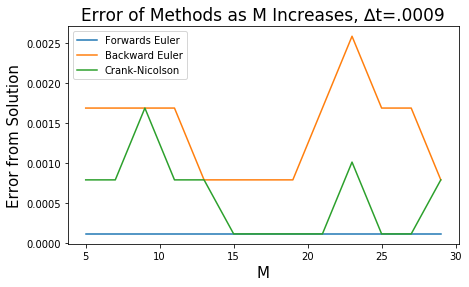

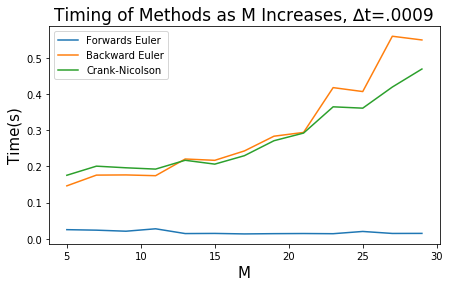

In [22]:
solution = 0.424011387033 # Real solution from write-up
M_vals = np.linspace(5,29,13,dtype=int)
delta_t = .0009
drop = 1e-8
explicit_accs = []
implicit_accs = []
crank_accs = []
explicit_times = []
implicit_times = []
crank_times = []
for M in M_vals:
    fill = 5 / M**2 # Set fill value based on M
    s = time.time()
    explicit_accs.append(np.abs(solution - solve_explicit(M, delta_t)))
    explicit_times.append(time.time() - s)
    s = time.time()
    implicit_accs.append(np.abs(solution - solve_implicit(M + 2, delta_t, construct_back_matrix, drop, fill)))
    implicit_times.append(time.time() - s)
    s = time.time()
    crank_sol,_ = solve_implicit_crank(M + 2, delta_t, drop, fill)
    crank_accs.append(np.abs(solution - crank_sol))
    crank_times.append(time.time() - s)
plt.figure(figsize=(7,4))
plt.plot(M_vals,explicit_accs)
plt.plot(M_vals,implicit_accs)
plt.plot(M_vals,crank_accs)
plt.title("Error of Methods as M Increases, ∆t=.0009",fontsize = 17)
plt.xlabel("M",fontsize=15)
plt.ylabel("Error from Solution",fontsize=15)
plt.legend(["Forwards Euler","Backward Euler","Crank-Nicolson"])
plt.show()
plt.figure(figsize=(7,4))
plt.plot(M_vals,explicit_times)
plt.plot(M_vals,implicit_times)
plt.plot(M_vals,crank_times)
plt.title("Timing of Methods as M Increases, ∆t=.0009",fontsize = 17)
plt.xlabel("M",fontsize=15)
plt.ylabel("Time(s)",fontsize=15)
plt.legend(["Forwards Euler","Backward Euler","Crank-Nicolson"])
plt.show()

#### Explore accuracies and timing as $∆t$ increases, with M=27

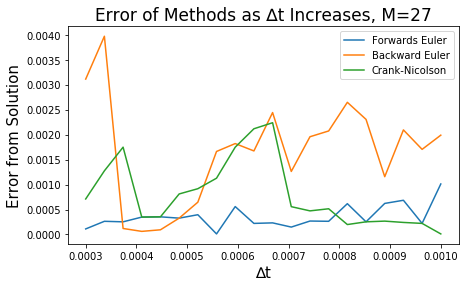

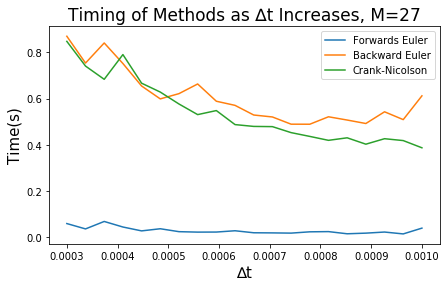

In [23]:
solution = 0.424011387033 # Real solution from write-up
M = 27
delta_t_vals = np.linspace(.001,.0003,20)
drop = 1e-8
explicit_accs = []
implicit_accs = []
crank_accs = []
explicit_times = []
implicit_times = []
crank_times = []
for delta_t in delta_t_vals:
    fill = 5 / M**2 # Set fill value based on M
    s = time.time()
    explicit_accs.append(np.abs(solution - solve_explicit(M, delta_t)))
    explicit_times.append(time.time() - s)
    s = time.time()
    implicit_accs.append(np.abs(solution - solve_implicit(M + 2, delta_t, construct_back_matrix, drop, fill)))
    implicit_times.append(time.time() - s)
    s = time.time()
    crank_sol,_ = solve_implicit_crank(M + 2, delta_t, drop, fill)
    crank_accs.append(np.abs(solution - crank_sol))
    crank_times.append(time.time() - s)
plt.figure(figsize=(7,4))
plt.plot(delta_t_vals,explicit_accs)
plt.plot(delta_t_vals,implicit_accs)
plt.plot(delta_t_vals,crank_accs)
plt.title("Error of Methods as ∆t Increases, M=27",fontsize = 17)
plt.xlabel("∆t",fontsize=15)
plt.ylabel("Error from Solution",fontsize=15)
plt.legend(["Forwards Euler","Backward Euler","Crank-Nicolson"])
plt.show()
plt.figure(figsize=(7,4))
plt.plot(delta_t_vals,explicit_times)
plt.plot(delta_t_vals,implicit_times)
plt.plot(delta_t_vals,crank_times)
plt.title("Timing of Methods as ∆t Increases, M=27",fontsize = 17)
plt.xlabel("∆t",fontsize=15)
plt.ylabel("Time(s)",fontsize=15)
plt.legend(["Forwards Euler","Backward Euler","Crank-Nicolson"])
plt.show()

While these graphs cannot paint an entire picture of how these methods compare, there are a few key takeaways. Firstly, the Backward Euler and Crank Nicolson Methods tend to be slower than the Forward Euler Method, and their timings increase at a quick quadratic rate, relative to the Forward Euler Method. There is also a trend that the error will decrease as $∆t$ decreases and as $M$ increases, although the implicit methods can be slightly oscillatory. I have run these tests with multiple ranges of hyper-parameters and found that the Forward Euler Method tends to be the quickest and most accurate. It is difficult to display these results within the 2-minute runtime of the assignment, but the above results show the trend.

### Best Possible Accuracy within $1$ Minute

As stated above, it would be impossible to show all of my results in this notebook as it would take too long to run. What I have found however is that the Forward Euler Method is the quickest method, and the best way to optimize its accuracy is with a sufficiently small $∆t$. As per the convergence, given a value $∆t$, the maximum $M_{max}$ value will be $\dfrac{1}{\sqrt{∆t}}-1$. I have found that using this maximum $M_{max}$ will generally yeild the best results, however having a smaller $M$ value will often help the run time significantly, at a small cost for accuracy. For this reason, I have found that the best way to acheive optimal accuracy in a reasonable timeframe is to first pick a small $∆t$, solve for $M_{max}$, then set $M\approx \dfrac{M_{max}}{6}$, as this will significantly speed up run time at a low cost of accuracy. To exemplify this point, I will display some results I gathered which I will not run in this notebook (due to slow runtime). First I picked I small $∆t$ value of $10^{-6}$. I calculated the maximum $M$ value $M_{max}=999$. I then ran the Forward Euler Method using $M=\dfrac{M_{max}}{2},\dfrac{M_{max}}{4},\dfrac{M_{max}}{6},\dfrac{M_{max}}{8},\dfrac{M_{max}}{10}$. Below is a graph of the Error and the timing for each of the trials

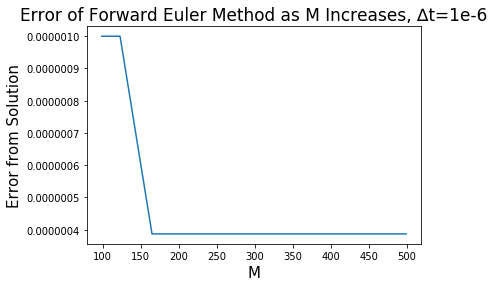

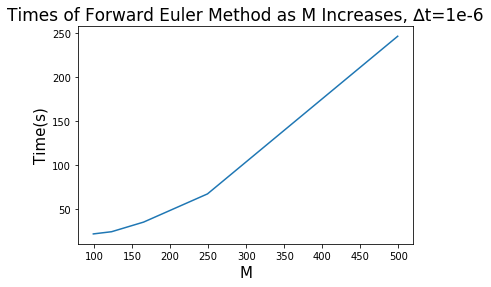

In [24]:
delta_t = 1e-6
M_vals = [499,249,165,123,99]
times = [246.59,67.16,35.06,24.14,21.63]
errors = [3.87e-7,3.87e-7,3.87e-7,1e-6,1e-6]
plt.plot(M_vals,errors)
plt.title("Error of Forward Euler Method as M Increases, ∆t=1e-6",fontsize = 17)
plt.xlabel("M",fontsize=15)
plt.ylabel("Error from Solution",fontsize=15)
plt.show()
plt.plot(M_vals,times)
plt.title("Times of Forward Euler Method as M Increases, ∆t=1e-6",fontsize = 17)
plt.xlabel("M",fontsize=15)
plt.ylabel("Time(s)",fontsize=15)
plt.show()

As you can see in the graphs above, the error remains the same for $M=\dfrac{M_{max}}{2},\dfrac{M_{max}}{4},\dfrac{M_{max}}{6}$, although the timing significantly increases as M gets larger. I have found that as $M_{max}$ becomes larger, it is suitable to divide it by a greater factor while producing good results. For my final solution I use $∆t=5*10^{-7}$, which produces $M_{max}=1413$. I then use a factor of $9.5$ to divide $M_{max}$, setting $M=\dfrac{M_{max}}{9.5}\approx 157$. The final solution is:<br>
$t*=0.4240115$<br>
This is correct to $6$ decimals and has error $\approx 1.13*10^{-7}$ from the actual solution of $0.424011387033$. The final run time on my machine was $60.86$ seconds.

In [25]:
delta_t = 5e-7 # Set small delta_t
M_max = int(1/np.sqrt(delta_t) - 1) # Solve for maximum M
div_factor = 9.5 # Set factor to divide M_max by
M = int(M_max / div_factor) # Set M from M_max and div factor
if not(M % 2): # Ensure that M is odd (for clear central value)
    M -= 1
s = time.time()
print("Final t*:",solve_explicit(M,delta_t))
print("Final run time:",format(time.time()-s,".2f"),"seconds")

Final t*: 0.4240115
Final run time: 64.52 seconds
